In [1]:
import sys
sys.path.append("..")


In [2]:
import os
import shutil
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import json
import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from utils.split_dataset_v1 import organize_data_splits
from utils.visualize_v1 import display_class_distribution
from models.model_v1 import PlantDiseaseResNet18

from utils.grad_cam_v1 import visualize_single_image, export_batch_visualizations
from PIL import Image
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             precision_recall_fscore_support, confusion_matrix,
                             classification_report)


In [3]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")
if torch.cuda.is_available():
    torch.cuda.set_device(device)
    print(f"Using GPU: {device}")
    print(f"GPU Name: {torch.cuda.get_device_name(device)}")
    
else:
    print("CUDA not available!")
print(f"Running on {device}")

Running on cuda:1
Using GPU: cuda:1
GPU Name: Tesla P100-PCIE-12GB
Running on cuda:1


Dataset Visualization

In [4]:


source_path="/home/sonia/RM/PlantVillage"
destination_path="/home/sonia/RM/PlantVillage_split"
class_count=display_class_distribution(source_path)



CLASS DISTRIBUTION SPLITTING
Pepper__bell___Bacterial_spot :   997 images (4.83%)
Pepper__bell___healthy :  1478 images (7.16%)
Potato___Early_blight :  1000 images (4.85%)
Potato___Late_blight :  1000 images (4.85%)
Potato___healthy     :   152 images (0.74%)
Tomato_Bacterial_spot :  2127 images (10.31%)
Tomato_Early_blight  :  1000 images (4.85%)
Tomato_Late_blight   :  1909 images (9.25%)
Tomato_Leaf_Mold     :   952 images (4.61%)
Tomato_Septoria_leaf_spot :  1771 images (8.58%)
Tomato_Spider_mites_Two_spotted_spider_mite :  1676 images (8.12%)
Tomato__Target_Spot  :  1404 images (6.80%)
Tomato__Tomato_YellowLeaf__Curl_Virus :  3209 images (15.55%)
Tomato__Tomato_mosaic_virus :   373 images (1.81%)
Tomato_healthy       :  1591 images (7.71%)
--------------------------------------------------
TOTAL                : 20639 images



In [5]:
def plot_class_distribution(class_info):
    total_count = sum(class_info.values())
    sorted_classes = sorted(class_info.items(), key=lambda x: x[1], reverse=True)
    labels = [item[0] for item in sorted_classes]
    counts = [item[1] for item in sorted_classes]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.Pastel1(range(len(labels)))
    bars = ax.barh(labels, counts, color=colors, edgecolor='black', linewidth=1.2)
    
    ax.set_xlabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_ylabel('Class Names', fontsize=12, fontweight='bold')
    ax.set_title('Dataset Distribution by Class', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    for idx, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f' {int(width)} ({counts[idx]/total_count*100:.1f}%)',
                ha='left', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

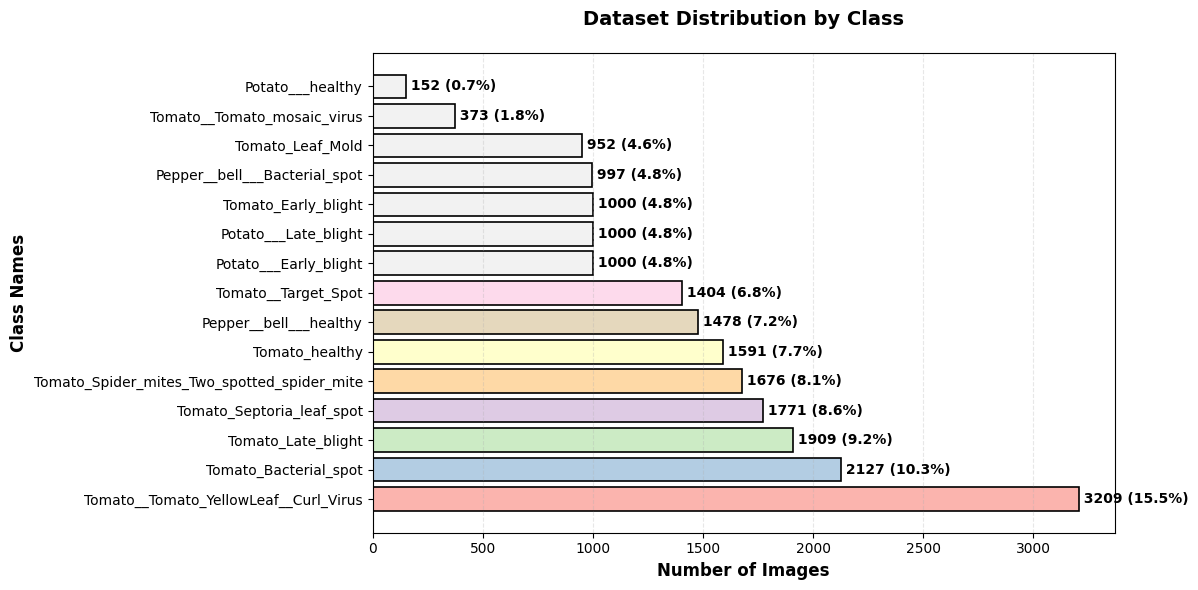

In [6]:
plot_class_distribution(class_count)

Splitting Dataset into Train Test Val 70-15-15

In [7]:
organize_data_splits(source_path,destination_path)

Destination folder already exists!
Path: /home/sonia/RM/PlantVillage_split



===== TRAIN DISTRIBUTION =====

CLASS DISTRIBUTION SPLITTING
Pepper__bell___Bacterial_spot :   697 images (4.83%)
Pepper__bell___healthy :  1034 images (7.16%)
Potato___Early_blight :   700 images (4.85%)
Potato___Late_blight :   700 images (4.85%)
Potato___healthy     :   106 images (0.73%)
Tomato_Bacterial_spot :  1488 images (10.30%)
Tomato_Early_blight  :   700 images (4.85%)
Tomato_Late_blight   :  1336 images (9.25%)
Tomato_Leaf_Mold     :   666 images (4.61%)
Tomato_Septoria_leaf_spot :  1239 images (8.58%)
Tomato_Spider_mites_Two_spotted_spider_mite :  1173 images (8.12%)
Tomato__Target_Spot  :   982 images (6.80%)
Tomato__Tomato_YellowLeaf__Curl_Virus :  2246 images (15.55%)
Tomato__Tomato_mosaic_virus :   261 images (1.81%)
Tomato_healthy       :  1113 images (7.71%)
--------------------------------------------------
TOTAL                : 14441 images



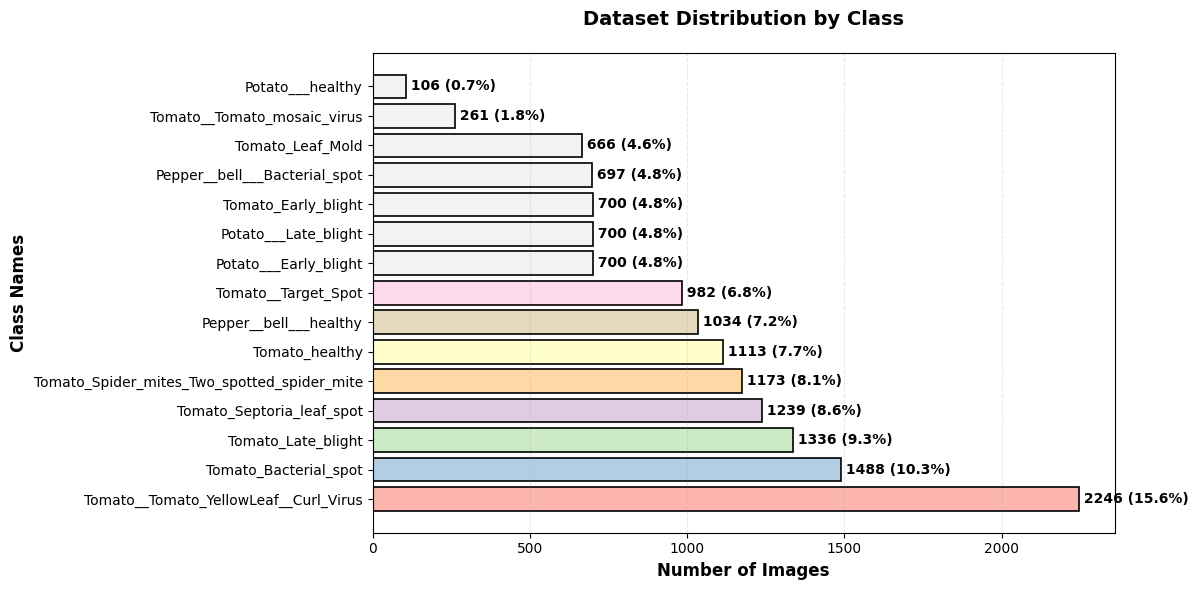


===== VAL DISTRIBUTION =====

CLASS DISTRIBUTION SPLITTING
Pepper__bell___Bacterial_spot :   149 images (4.82%)
Pepper__bell___healthy :   221 images (7.15%)
Potato___Early_blight :   150 images (4.86%)
Potato___Late_blight :   150 images (4.86%)
Potato___healthy     :    22 images (0.71%)
Tomato_Bacterial_spot :   319 images (10.33%)
Tomato_Early_blight  :   150 images (4.86%)
Tomato_Late_blight   :   286 images (9.26%)
Tomato_Leaf_Mold     :   142 images (4.60%)
Tomato_Septoria_leaf_spot :   265 images (8.58%)
Tomato_Spider_mites_Two_spotted_spider_mite :   251 images (8.13%)
Tomato__Target_Spot  :   210 images (6.80%)
Tomato__Tomato_YellowLeaf__Curl_Virus :   481 images (15.57%)
Tomato__Tomato_mosaic_virus :    55 images (1.78%)
Tomato_healthy       :   238 images (7.70%)
--------------------------------------------------
TOTAL                :  3089 images



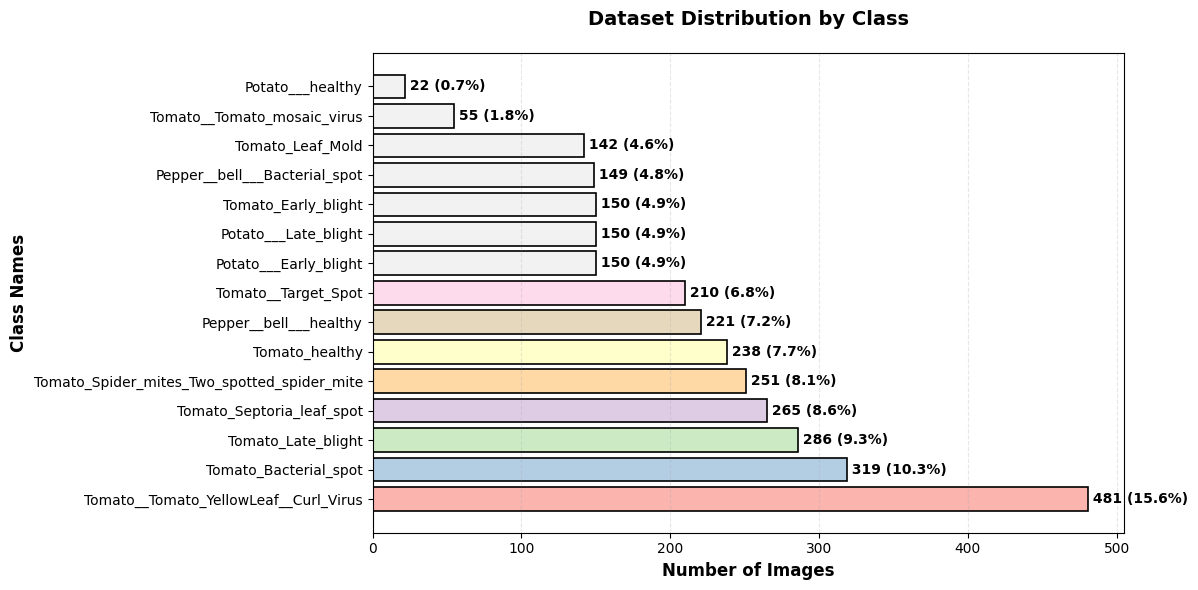


===== TEST DISTRIBUTION =====

CLASS DISTRIBUTION SPLITTING
Pepper__bell___Bacterial_spot :   151 images (4.86%)
Pepper__bell___healthy :   223 images (7.17%)
Potato___Early_blight :   150 images (4.82%)
Potato___Late_blight :   150 images (4.82%)
Potato___healthy     :    24 images (0.77%)
Tomato_Bacterial_spot :   320 images (10.29%)
Tomato_Early_blight  :   150 images (4.82%)
Tomato_Late_blight   :   287 images (9.23%)
Tomato_Leaf_Mold     :   144 images (4.63%)
Tomato_Septoria_leaf_spot :   267 images (8.59%)
Tomato_Spider_mites_Two_spotted_spider_mite :   252 images (8.11%)
Tomato__Target_Spot  :   212 images (6.82%)
Tomato__Tomato_YellowLeaf__Curl_Virus :   482 images (15.50%)
Tomato__Tomato_mosaic_virus :    57 images (1.83%)
Tomato_healthy       :   240 images (7.72%)
--------------------------------------------------
TOTAL                :  3109 images



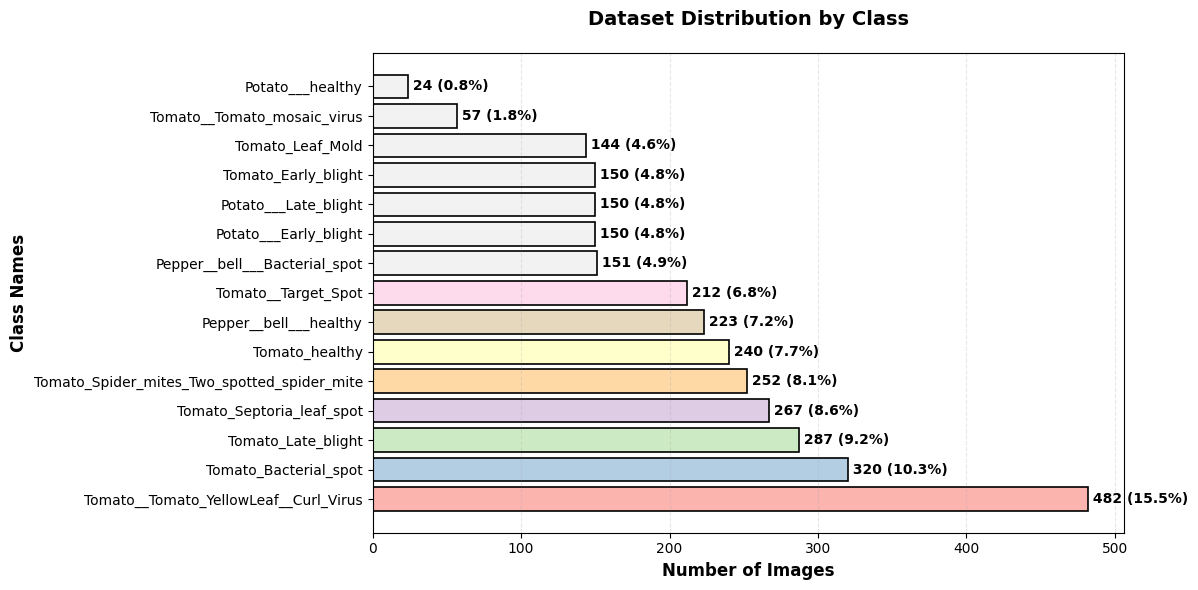

In [8]:
splits = ["train", "val", "test"]

for split in splits:
    split_path = os.path.join(destination_path, split)
    
    print(f"\n===== {split.upper()} DISTRIBUTION =====")
    
    class_info = display_class_distribution(split_path) 
    
    plot_class_distribution(class_info)  

Training and Testing

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
train_dir, val_dir, test_dir = [os.path.join(destination_path, s) for s in ["train", "val", "test"]]


train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [11]:

num_classes = len(train_dataset.classes)
model = PlantDiseaseResNet18(num_classes=num_classes, pretrained=False)



In [12]:
print(model)

PlantDiseaseResNet18(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model = model.to(device)

In [14]:


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss_total = 0.0
    correct_count = 0
    sample_count = 0

    for batch_data, batch_targets in loader:
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()
        model_output = model(batch_data)
        loss_value = criterion(model_output, batch_targets)

        loss_value.backward()
        optimizer.step()

        running_loss_total += loss_value.item()

        pred_labels = torch.argmax(model_output, dim=1)
        sample_count += batch_targets.shape[0]
        correct_count += torch.sum(pred_labels == batch_targets).item()

    avg_epoch_loss = running_loss_total / len(loader)
    epoch_accuracy = (correct_count / sample_count) * 100
    
    return avg_epoch_loss, epoch_accuracy


def validate(model, loader, criterion, device):
    model.eval()
    running_loss_total = 0.0
    prediction_list = []
    target_list = []

    with torch.no_grad():
        for batch_data, batch_targets in loader:
            batch_data = batch_data.to(device)
            batch_targets = batch_targets.to(device)

            model_output = model(batch_data)
            loss_value = criterion(model_output, batch_targets)
            running_loss_total += loss_value.item()

            pred_labels = torch.argmax(model_output, dim=1)
            prediction_list.extend(pred_labels.cpu().numpy())
            target_list.extend(batch_targets.cpu().numpy())

    predictions_np = np.array(prediction_list)
    targets_np = np.array(target_list)

    avg_epoch_loss = running_loss_total / len(loader)
    epoch_accuracy = np.sum(predictions_np == targets_np) / len(targets_np) * 100

    prec_score = precision_score(targets_np, predictions_np, average='weighted', zero_division=0)
    rec_score = recall_score(targets_np, predictions_np, average='weighted', zero_division=0)
    f1_value = f1_score(targets_np, predictions_np, average='weighted', zero_division=0)

    return avg_epoch_loss, epoch_accuracy, prec_score, rec_score, f1_value


TRAINING_EPOCHS = 50
performance_history = {
    "train_loss": [], 
    "train_acc": [],
    "val_loss": [], 
    "val_acc": [],
    "val_precision": [], 
    "val_recall": [], 
    "val_f1": []
}

best_val_accuracy = 0.0

for epoch_idx in range(TRAINING_EPOCHS):
    t_start = time.time()

    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    v_loss, v_acc, v_precision, v_recall, v_f1 = validate(model, val_loader, criterion, device)

    scheduler.step()

    performance_history["train_loss"].append(tr_loss)
    performance_history["train_acc"].append(tr_acc)
    performance_history["val_loss"].append(v_loss)
    performance_history["val_acc"].append(v_acc)
    performance_history["val_precision"].append(v_precision)
    performance_history["val_recall"].append(v_recall)
    performance_history["val_f1"].append(v_f1)

    print(f"Epoch [{epoch_idx+1}/{TRAINING_EPOCHS}]")
    print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.2f}%")
    print(f"Val   Loss: {v_loss:.4f} | Val Acc: {v_acc:.2f}%")
    print(f"Val Precision: {v_precision:.4f} | Val Recall: {v_recall:.4f} | Val F1: {v_f1:.4f}")
    print(f"Time: {(time.time()-t_start):.2f}s")
    print("-" * 50)

    if v_acc > best_val_accuracy:
        print("Saving best model...")
        torch.save(model.state_dict(), "../models/model_v1.pth")
        best_val_accuracy = v_acc

results_df = pd.DataFrame(performance_history)
results_df.index = np.arange(1, len(results_df) + 1)
results_df.to_csv("../results/model_training_history1.csv", index_label="epoch")

print("Metrics saved to ../results/model_training_history1.csv")

Epoch [1/50]
Train Loss: 1.3701 | Train Acc: 56.95%
Val   Loss: 0.6017 | Val Acc: 80.48%
Val Precision: 0.8151 | Val Recall: 0.8048 | Val F1: 0.7968
Time: 43.38s
--------------------------------------------------
Saving best model...
Epoch [2/50]
Train Loss: 0.7176 | Train Acc: 76.39%
Val   Loss: 0.3838 | Val Acc: 87.63%
Val Precision: 0.8825 | Val Recall: 0.8763 | Val F1: 0.8756
Time: 42.98s
--------------------------------------------------
Saving best model...
Epoch [3/50]
Train Loss: 0.5639 | Train Acc: 81.50%
Val   Loss: 0.3423 | Val Acc: 88.64%
Val Precision: 0.8942 | Val Recall: 0.8864 | Val F1: 0.8858
Time: 42.76s
--------------------------------------------------
Saving best model...
Epoch [4/50]
Train Loss: 0.4305 | Train Acc: 85.68%
Val   Loss: 0.3598 | Val Acc: 87.96%
Val Precision: 0.8923 | Val Recall: 0.8796 | Val F1: 0.8779
Time: 44.08s
--------------------------------------------------
Epoch [5/50]
Train Loss: 0.3561 | Train Acc: 88.19%
Val   Loss: 0.1945 | Val Acc: 93.

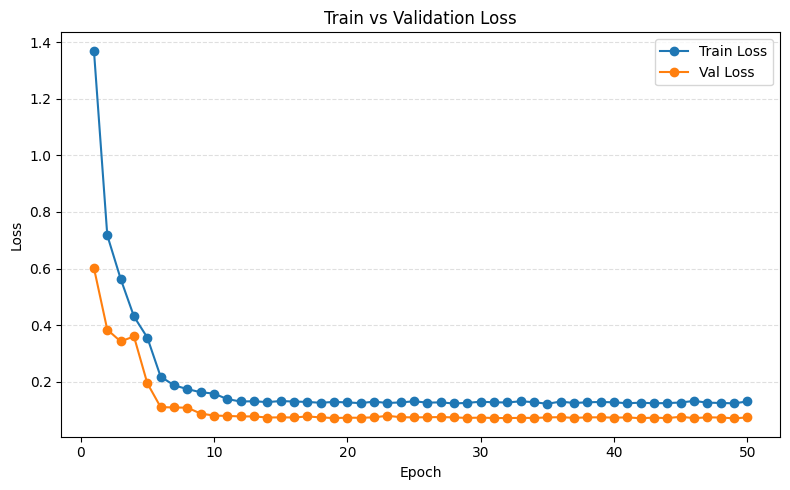

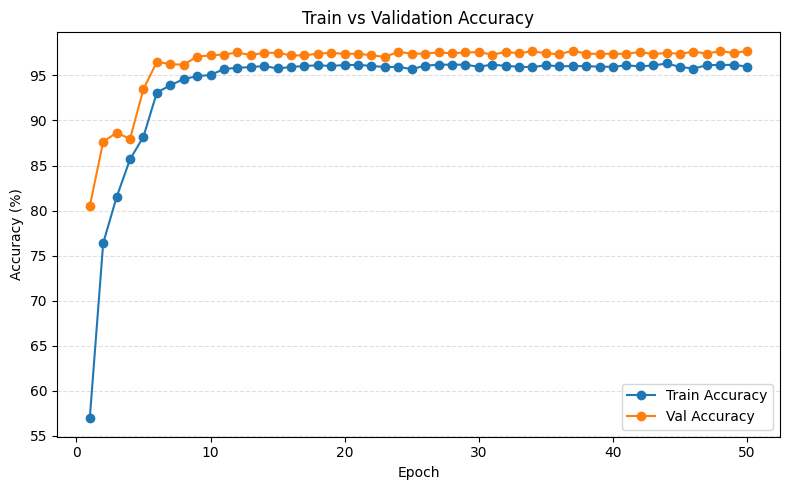

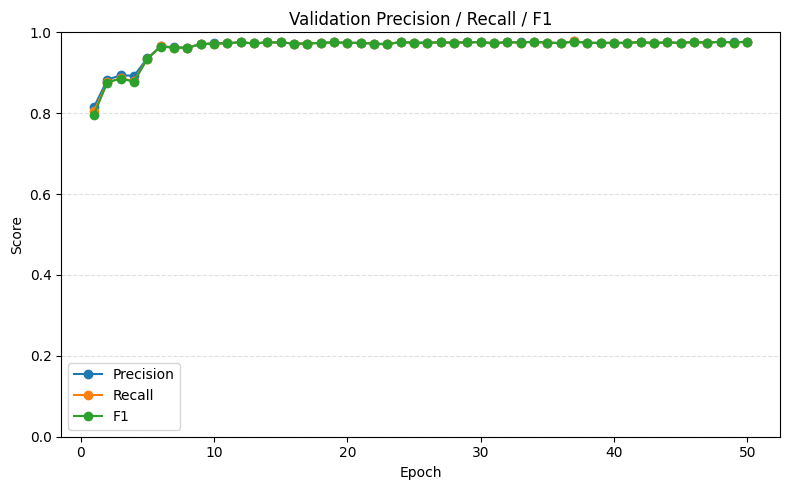

Charts saved to directory: ../results/plots_v1


In [15]:
output_folder = "../results/plots_v1"
os.makedirs(output_folder, exist_ok=True)

data_copy = results_df.copy()

for c in data_copy.columns:
    data_copy[c] = pd.to_numeric(data_copy[c], errors="coerce")

epoch_vals = data_copy.index.values

plt.figure(figsize=(8, 5))
plt.plot(epoch_vals, data_copy["train_loss"], "o-", label="Train Loss")
plt.plot(epoch_vals, data_copy["val_loss"], "o-", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(f"{output_folder}/loss_curve.png", dpi=150)
plt.show()
plt.close('all')

plt.figure(figsize=(8, 5))
plt.plot(epoch_vals, data_copy["train_acc"], "o-", label="Train Accuracy")
plt.plot(epoch_vals, data_copy["val_acc"], "o-", label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(f"{output_folder}/accuracy_curve.png", dpi=150)
plt.show()
plt.close('all')

plt.figure(figsize=(8, 5))
plt.plot(epoch_vals, data_copy["val_precision"], "o-", label="Precision")
plt.plot(epoch_vals, data_copy["val_recall"], "o-", label="Recall")
plt.plot(epoch_vals, data_copy["val_f1"], "o-", label="F1")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Precision / Recall / F1")
plt.ylim(0.0, 1.0)
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(f"{output_folder}/val_prf_curve.png", dpi=150)
plt.show()
plt.close('all')

print(f"Charts saved to directory: {output_folder}")